In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import Image

import matplotlib as mpl
mpl.rcParams.update({'font.size': 10})

from lmfit.models import gaussian, lorentzian

%matplotlib nbagg

In [2]:
def sin(theta):
    return np.sin(theta*np.pi/180.)

def cos(theta):
    return np.cos(theta*np.pi/180.)

## Load RIXS

In [3]:
with open('120meV_exchange/RIXS_pol_11_out.spec') as fin:
    header = [fin.readline() for n in range(4)]

num_spectra = int(header[0][:-1].split(' ')[-1])
Emin1, Emax1 = -7., -3.
E1 = np.linspace(Emin1, Emax1, num_spectra)

file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(1, 1)
data = np.loadtxt(file_name, skiprows=5)
E2 = data[:,0]
RIXSmap = data[:,2::2]

In [4]:
def get_rixs(out_pol, in_pol):
    cutrow = 300

    file_name = 'zero_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap0 = -data[:,2::2]
    
    file_name = '120meV_exchange/RIXS_pol_{}{}_out.spec'.format(out_pol, in_pol)
    data = np.loadtxt(file_name, skiprows=5)
    RIXSmap120 = -data[:,2::2]
    
    RIXSmap = np.vstack((RIXSmap120[:cutrow], RIXSmap0[cutrow:]))
    
    return RIXSmap

pol_iter = [(out_pol, in_pol) for out_pol in range(3) for in_pol in range(3)]
RIXSmaps = [get_rixs(out_pol+1, in_pol+1) for out_pol, in_pol in pol_iter]

## Get XAS

In [5]:
XAS = sum(RIXSmaps).sum(axis=0)
#fig, ax = plt.subplots()
#ax.plot(E1, XAS, '.-')
Eres = E1[np.argmax(XAS)]
print('Resonance at {:.3f}'.format(Eres))

Resonance at -5.200


## Get and plot spectra

<IPython.core.display.Javascript object>


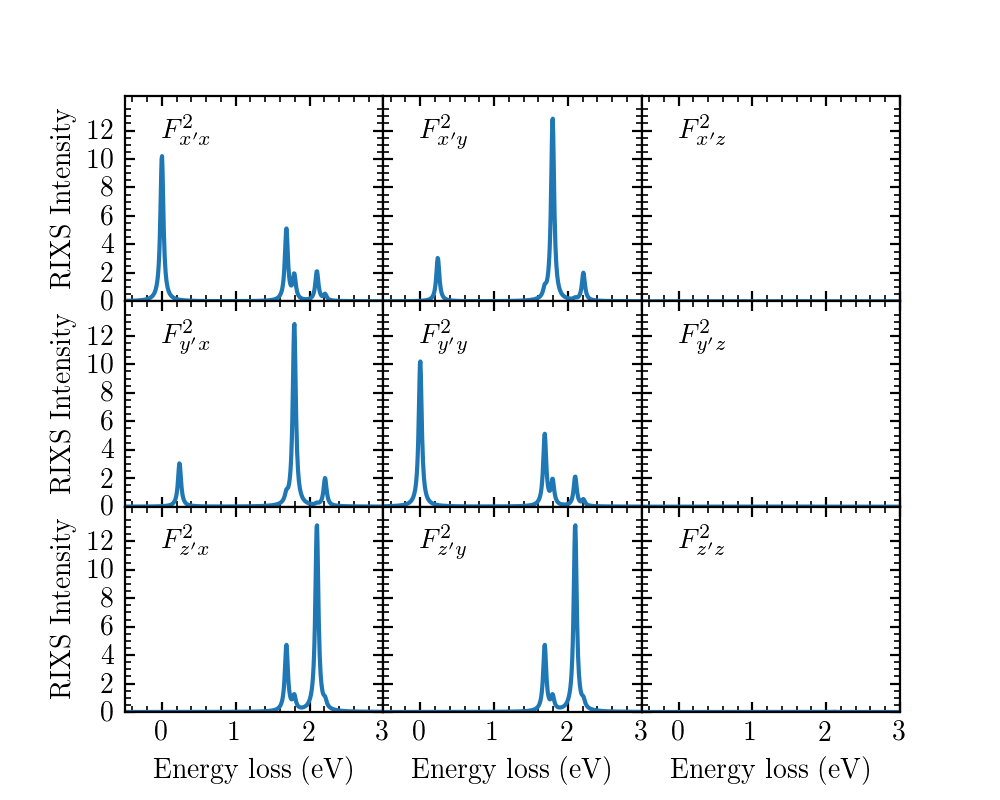

In [6]:
xyz = ['x', 'y', 'z']
fig, axs = plt.subplots(3, 3, figsize=(5.,4))
axs = axs.ravel()

spectra = [RIXSmap[:,np.argmax(XAS)] for RIXSmap in RIXSmaps]
maxval = max(spectrum.max() for spectrum in spectra)

for spectrum, ax, (out_pol, in_pol) in zip(spectra, axs, pol_iter):
    ax.plot(E2, spectrum, '-')
    ax.set_xticks(np.arange(0, 4))
    ax.set_yticks(np.arange(0, 13, 2))
    #ax.legend(loc=2)
    ax.axis([-0.5, 3, 0, maxval*1.1])
    #ax.tick_params(which='major', direction='in', bottom=True, top=True, left=True, right=True, length=5)
    #ax.tick_params(which='minor', direction='in', bottom=True, top=True, left=True, right=True, length=2)
    #ax.minorticks_on()
    #ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    #ax.yaxis.set_minor_locator(MultipleLocator(1))
    
    ax.text(0, 11, '$F_{' + xyz[out_pol] + '^\prime ' + xyz[in_pol] + '}^2$')

[ax.set_xlabel('Energy loss (eV)') for ax, (out_pol, in_pol) in zip(axs, pol_iter) if out_pol == 2]
[ax.set_ylabel('RIXS Intensity') for ax, (out_pol, in_pol) in zip(axs, pol_iter) if in_pol == 0]
[ax.set_xticklabels('') for ax, (out_pol, in_pol) in zip(axs, pol_iter) if out_pol is not 2]
[ax.set_yticklabels('') for ax, (out_pol, in_pol) in zip(axs, pol_iter) if in_pol is not 0]

fig.subplots_adjust(hspace=0, wspace=0)

## Compute Spectra in arbitary polarization

In [7]:
spectra_matrix = np.zeros((len(E2), 3, 3))
for spectrum, (in_pol, out_pol) in zip(spectra, pol_iter):
    spectra_matrix[:, in_pol, out_pol] = spectrum

maxval = np.max(spectra_matrix)

In [8]:
def get_orbital_ints(th_i, tth, in_pol, out_pol):
    th_o = 180. - tth - th_i
    if in_pol == 'sigma':
        absorption_pol = np.array([0, 1, 0])
    elif in_pol == 'pi':
        absorption_pol = np.array([sin(th_i), 0, cos(th_i)])
    
    if out_pol == 'sigma':
        emitted_pol = np.array([0, 1, 0])
    elif out_pol == 'pi':
        emitted_pol = np.array([sin(th_o), 0, cos(th_o)])

    M = np.outer(emitted_pol, absorption_pol)
    spectrum_at_pol = np.abs((M*spectra_matrix).sum(axis=(1,2)))**2

    phonon = np.interp(0.00, E2, spectrum_at_pol)
    mag = np.interp(0.25, E2, spectrum_at_pol)
    z = np.interp(1.68, E2, spectrum_at_pol)
    xy = np.interp(1.79, E2, spectrum_at_pol)
    xz = np.interp(2.10, E2, spectrum_at_pol)
    
    return phonon, mag, z, xy, xz

def make_spectrum(E2, th_i, tth, res, orbital_width, in_pol, out_pol):
    phonon, mag, z, xy, xz = get_orbital_ints(th_i, tth, in_pol, out_pol)
    y = gaussian(E2, phonon*11/12, 0., res) #specular
    y += gaussian(E2, phonon*1/12, 0.09, res) #phonon
    y += gaussian(E2, mag, 0.25, res) #phonon
    y += lorentzian(E2, z, 1.68, orbital_width) 
    y += lorentzian(E2, xz, 1.79, orbital_width) 
    y += lorentzian(E2, xz, 2.10, orbital_width) 
    return y

## Spectrum in arbitary configuration

<IPython.core.display.Javascript object>


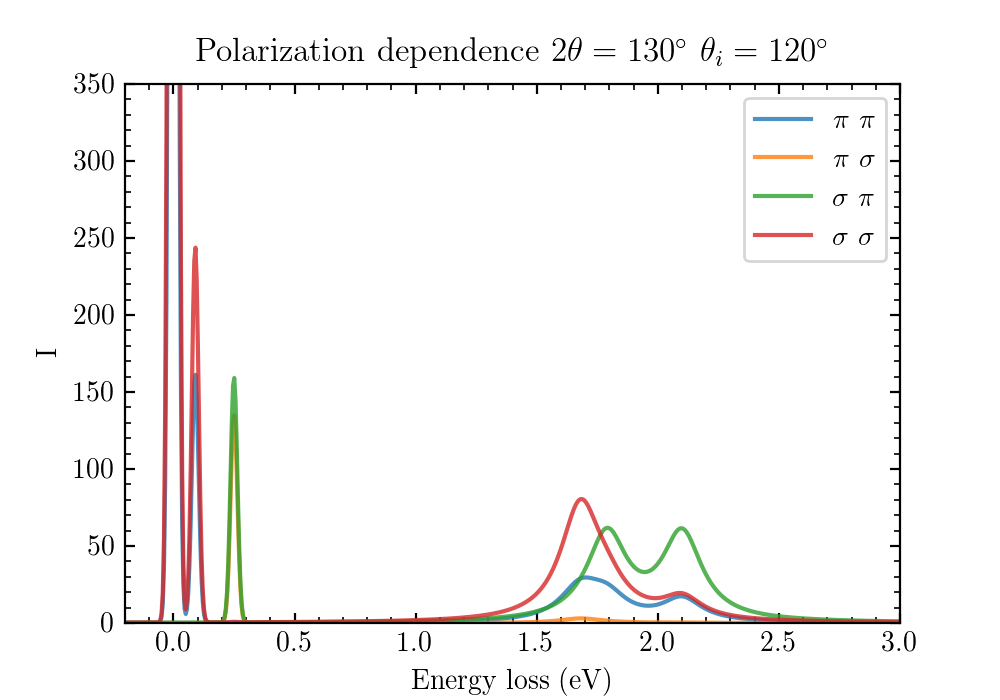

In [9]:
th_i = 120.
tth = 130.
res = 0.014
orbital_width = 0.1

eloss = np.linspace(-1, 4, 1000)

pi_pi_CS = make_spectrum(eloss, th_i, tth, res, orbital_width, 'pi', 'pi')
pi_sigma_CS = make_spectrum(eloss, th_i, tth, res, orbital_width, 'pi', 'sigma')
sigma_pi_CS = make_spectrum(eloss, th_i, tth, res, orbital_width, 'sigma', 'pi')
sigma_sigma_CS = make_spectrum(eloss, th_i, tth, res, orbital_width, 'sigma', 'sigma')

fig, ax = plt.subplots(figsize=(5, 3.5))
ax.plot(eloss, pi_pi_CS, '-', label='$\pi$ $\pi$', alpha=0.8)
ax.plot(eloss, pi_sigma_CS, '-', label='$\pi$ $\sigma$', alpha=0.8)
ax.plot(eloss, sigma_pi_CS, '-', label='$\sigma$ $\pi$', alpha=0.8)
ax.plot(eloss, sigma_sigma_CS, '-', label='$\sigma$ $\sigma$', alpha=0.8)

ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')
ax.axis([-0.2, 3, 0, 350])
ax.legend()

ax.set_title(r'Polarization dependence $2\theta = 130^{\circ}$ $\theta_i  = 120^{\circ}$')

fig.savefig('pol_dep.pdf', dpi=1200)

## Save Cross Sections

In [18]:
np.savez('cross_sections.npz', eloss=eloss, pi_pi_CS=pi_pi_CS, pi_sigma_CS=pi_sigma_CS, 
        sigma_pi_CS=sigma_pi_CS, sigma_sigma_CS=sigma_sigma_CS)

In [10]:
def make_spectrum(CS, nphonons=30):
    split = 20
    prob =  CS/np.max(CS)/split
    
    spectrum = np.zeros_like(CS)
    for n in range(int(nphonons*split)):
        spectrum[prob > np.random.rand(CS.size)] += 1
    return spectrum

<IPython.core.display.Javascript object>


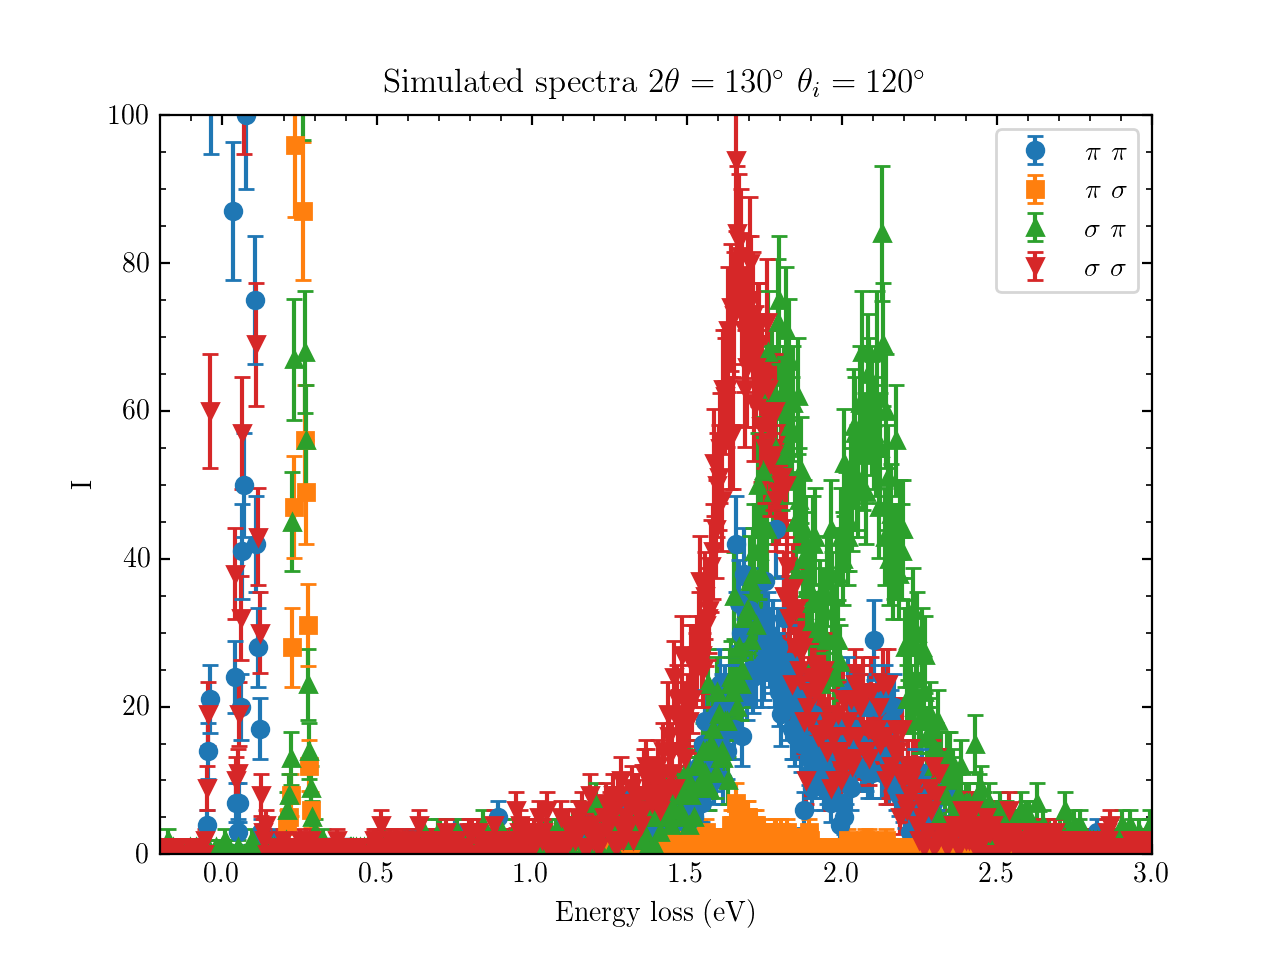

In [12]:
fig, ax = plt.subplots()

scaling = 1
spectrum = make_spectrum(pi_pi_CS, pi_pi_CS.max()/scaling)
ax.errorbar(eloss, spectrum, np.sqrt(spectrum), fmt='o', label='$\pi$ $\pi$')

spectrum = make_spectrum(pi_sigma_CS, pi_sigma_CS.max()/scaling)
ax.errorbar(eloss, spectrum, np.sqrt(spectrum), fmt='s', label='$\pi$ $\sigma$')

spectrum = make_spectrum(sigma_pi_CS, sigma_pi_CS.max()/scaling)
ax.errorbar(eloss, spectrum, np.sqrt(spectrum), fmt='^', label='$\sigma$ $\pi$')

spectrum = make_spectrum(sigma_sigma_CS, sigma_sigma_CS.max()/scaling)
ax.errorbar(eloss, spectrum, np.sqrt(spectrum), fmt='v', label='$\sigma$ $\sigma$')

ax.legend()
ax.set_xlabel('Energy loss (eV)')
ax.set_ylabel('I')
ax.axis([-0.2, 3, 0, 100])

ax.set_title(r'Simulated spectra $2\theta = 130^{\circ}$ $\theta_i  = 120^{\circ}$')